In [23]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from typing import Iterator, Iterable

In [29]:
DATA_PATH = Path() / ".." / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
CLEAN_DATA_PATH = DATA_PATH / "clean"

TICKERS = ("a", "b", "c", "d")
FILE_NAME_PATTERN = "prices_*_*.csv"

START_TIME = pd.Timestamp("8:00").time()
END_TIME = pd.Timestamp("16:30").time()
LAST_DATE = "20170818"

STOCK_SPLITS: dict[str, dict[str, float]] = {
    "d": {"2017-05-22": 10}
}

In [25]:
raw_file_paths = sorted(RAW_DATA_PATH.glob(FILE_NAME_PATTERN))

raw_file_paths_ex_last = [
    file_path
    for file_path in raw_file_paths
    if LAST_DATE not in file_path.name
]
raw_file_paths_only_last = [
    file_path
    for file_path in raw_file_paths
    if LAST_DATE in file_path.name
]

In [ ]:
def load_price_frame(file_path: Path) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        dtype={"price": "float64"},
        parse_dates=["ts"],
    )


In [40]:
def clean_price_frame(frame: pd.DataFrame, splits: dict[str, float]) -> pd.DataFrame:
    return (
        frame
            .pipe(_filter_non_trading_hours)
            .pipe(_filter_zero_prices)
            .pipe(_combine_identical_timestamps)
            .pipe(_remove_outliers)
            .pipe(_adjust_for_splits, splits=splits)
            .pipe(_add_date_column)
    )

def _filter_non_trading_hours(frame: pd.DataFrame) -> pd.DataFrame:
    # P1
    return (
        frame
        .loc[lambda row: row["ts"].dt.time >= START_TIME]
        .loc[lambda row: row["ts"].dt.time <= END_TIME]
    )

def _filter_zero_prices(frame: pd.DataFrame) -> pd.DataFrame:
    # P2
    return (
        frame
        .loc[lambda row: row["price"] > 0]
    )

def _combine_identical_timestamps(frame: pd.DataFrame) -> pd.DataFrame:
    # T3
    return (
        frame
        .groupby("ts", as_index=False)
        .median()
    )

def _remove_outliers(frame: pd.DataFrame, window_size: int = 50, threshold: float = 10.0) -> pd.DataFrame:
    # Q4
    prices = frame["price"]

    if window_size % 2 != 0:
        raise ValueError("window_size must be even")

    half_window = window_size // 2

    # Define the median function excluding the middle value
    def _median_exclude_middle(x):
        without_middle = np.concatenate([x[:half_window], x[half_window+1:]])
        return np.median(without_middle)

    # Define the MAD function excluding the middle value
    def _mad_exclude_middle(x):
        without_middle = np.concatenate([x[:half_window], x[half_window+1:]])
        median = np.median(without_middle)
        return np.mean(np.abs(without_middle - median))

    # Calculate the rolling centered median excluding the current observation
    medians = prices.rolling(window=window_size, center=True, min_periods=1).apply(_median_exclude_middle, raw=True)

    # Calculate the rolling MAD excluding the current observation
    mads = prices.rolling(window=window_size, center=True, min_periods=1).apply(_mad_exclude_middle, raw=True)

    # Calculate the deviation from the rolling median
    deviations = np.abs(prices - medians)

    # Identify the outliers
    outliers = deviations > (threshold * mads)

    # Remove the outliers
    cleaned_frame = frame[~outliers]

    return cleaned_frame

def _adjust_for_splits(frame: pd.DataFrame, splits: dict[str, float]) -> pd.DataFrame:
    # copy to avoid side-effecting
    frame = frame.copy()

    for split_date_str, split_ratio in splits.items():
        split_date = pd.to_datetime(split_date_str, format="%Y-%m-%d")
        frame.loc[frame["ts"] < split_date, "price"] /= split_ratio

    return frame

def _add_date_column(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.copy()
    frame["date"] = frame["ts"].dt.date

    return frame

In [35]:
def load_clean_comine_price_frames(
    stock_file_paths: Iterator[Path],
    stock_splits: dict[str, float],
) -> pd.DataFrame:
    price_frames: list[pd.DataFrame] = []

    for file_path in stock_file_paths:
        price_frame = load_price_frame(file_path)

        if price_frame.empty:
            print(file_path)
            continue

        cleaned_price_frame = clean_price_frame(price_frame, splits=stock_splits)

        price_frames.append(cleaned_price_frame)

    return pd.concat(price_frames, ignore_index=True)


# def incremental_process(file_path: Path) -> pd.DataFrame:
#     price_frame = load_price_frame(file_path)
    

def base_process(stock: str, stock_file_paths: Iterator[Path], stock_splits: dict[str, float]) -> None:
    # Base processing and cleaning of stock files
    stock_frame = load_clean_comine_price_frames(stock_file_paths, stock_splits)

    # Store as partitioned parquets
    stock_frame.to_parquet(
        f"{CLEAN_DATA_PATH / 'prices' / stock}.parquet",
        index=False,
        partition_cols=["date"]
    )

    # Compute historical volatility
    hist_vol_frame = hist_vol_comp(stock_frame)

In [143]:
test_clean_frame = pd.read_parquet(f"{CLEAN_DATA_PATH / 'prices' / 'd'}.parquet")

<Axes: >

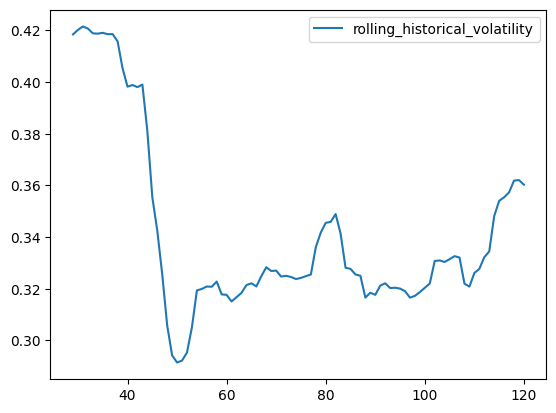

In [209]:
def hist_vol_comp(price_frame: pd.DataFrame, window: int = 30, num_trading_days: int = 252) -> pd.DataFrame:
    price_frame = price_frame.copy()
    prices = price_frame["price"]
    price_frame["log_return"] = np.log(prices / prices.shift(1))

    daily_realized_variance = (
        price_frame
            .groupby("date", observed=True)["log_return"]
            .apply(lambda group_vector: np.sum(group_vector.dropna()**2))
    )
    rolling_arv = daily_realized_variance.rolling(window=window).mean()
    annualized_rolling_arv = rolling_arv * num_trading_days

    return pd.DataFrame({
        "date": annualized_rolling_arv.index,
        "rolling_historical_volatility": np.sqrt(annualized_rolling_arv.values)
    })

hist_vol_comp(test_clean_frame).plot()

In [218]:
# RV approach

last_prices = test_clean_frame.groupby('date', observed=True)['price'].last().reset_index()
log_returns = np.log(last_prices["price"] / last_prices["price"].shift(1))

# Compute daily realized variance (squared log returns)
daily_realized_variance = log_returns**2

# Compute the rolling 30-day sum of daily realized variances
rolling_variance = daily_realized_variance.rolling(window=30).mean() * 252

# Convert rolling variance to volatility (annualized)
rolling_volatility = np.sqrt(rolling_variance)

plot_frame_0 = pd.DataFrame({
    "date": last_prices["date"],
    "rolling_historical_volatility": rolling_volatility
})

In [219]:
# STD Dev approach

last_prices = test_clean_frame.groupby('date', observed=True)['price'].last().reset_index()

last_prices["log_returns"] = np.log(last_prices["price"] / last_prices["price"].shift(1))

# Compute the rolling 30-day sum of daily realized variances
rolling_std = last_prices["log_returns"].rolling(window=30).std()

# Convert rolling variance to volatility (annualized)
rolling_volatility = rolling_std * np.sqrt(252)

plot_frame_1 = pd.DataFrame({
    "date": last_prices["date"],
    "rolling_historical_volatility": rolling_volatility
})

In [220]:
ohlc_df = test_clean_frame.set_index("ts")["price"].resample("B").ohlc()

gkyzhv = np.sqrt(
    (252 / 30) *
    pd.DataFrame.rolling(
        np.log(ohlc_df.loc[:, "open"] / ohlc_df.loc[:, "close"].shift(1)).fillna(0) ** 2 +
        0.5 * np.log(ohlc_df.loc[:, "high"] / ohlc_df.loc[:, "low"]).fillna(0) ** 2 -
        (2 * np.log(2) - 1) *
        np.log(ohlc_df.loc[:, "close"] / ohlc_df.loc[:, "open"]).fillna(0) ** 2,
        window=30
    ).sum()
)

plot_frame_2 = gkyzhv.to_frame().reset_index()

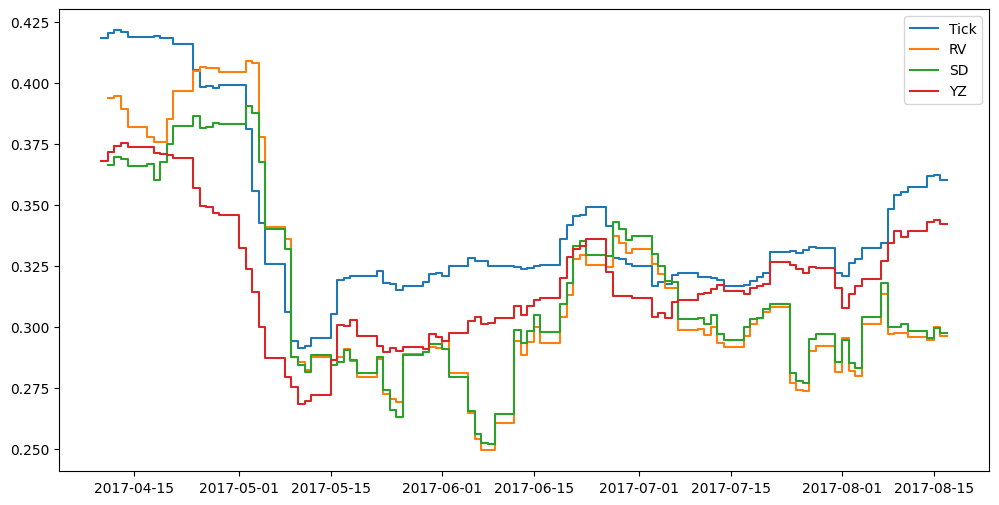

In [222]:
plt.figure(figsize=(12, 6))
plt.step(x=pd.to_datetime(hist_vol_comp(test_clean_frame)["date"]), y = hist_vol_comp(test_clean_frame)["rolling_historical_volatility"], label="Tick")
plt.step(x=pd.to_datetime(plot_frame_0["date"]), y=plot_frame_0["rolling_historical_volatility"], label="RV")
plt.step(x=pd.to_datetime(plot_frame_1["date"]), y=plot_frame_1["rolling_historical_volatility"], label="SD")
plt.step(x=plot_frame_2["ts"], y=plot_frame_2[0], label="YZ")
plt.legend()

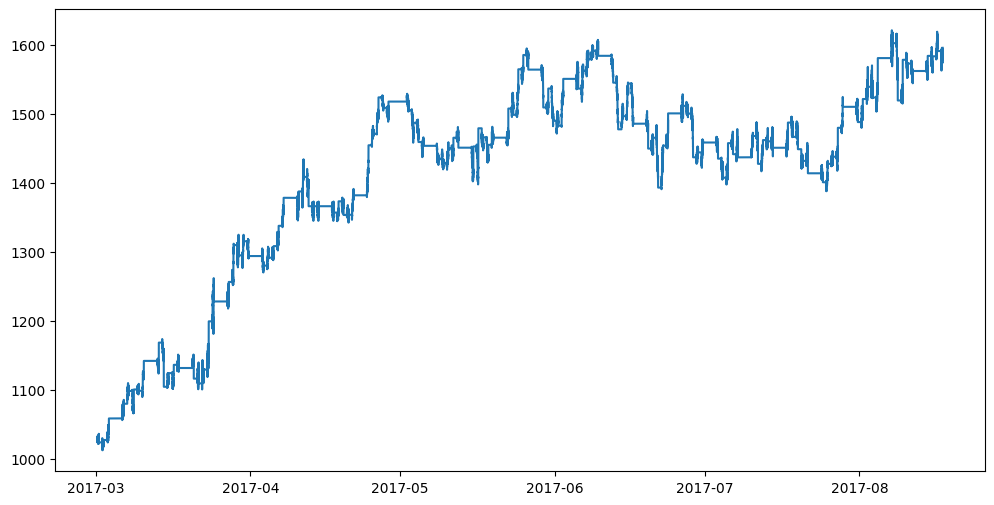

In [224]:
plot_frame = test_clean_frame

plt.figure(figsize=(12, 6))
plt.step(x=plot_frame["ts"], y=plot_frame["price"])

In [43]:
for stock, stock_file_paths in groupby(
    raw_file_paths_ex_last,
    key=lambda file_path: file_path.name.split("_")[1],
):
    base_process(stock, stock_file_paths, STOCK_SPLITS.get(stock, {}))

In [ ]:
pd.bdate_range(end=pd.to_datetime("2017-05-30", format="%Y-%m-%d"), periods=30).date

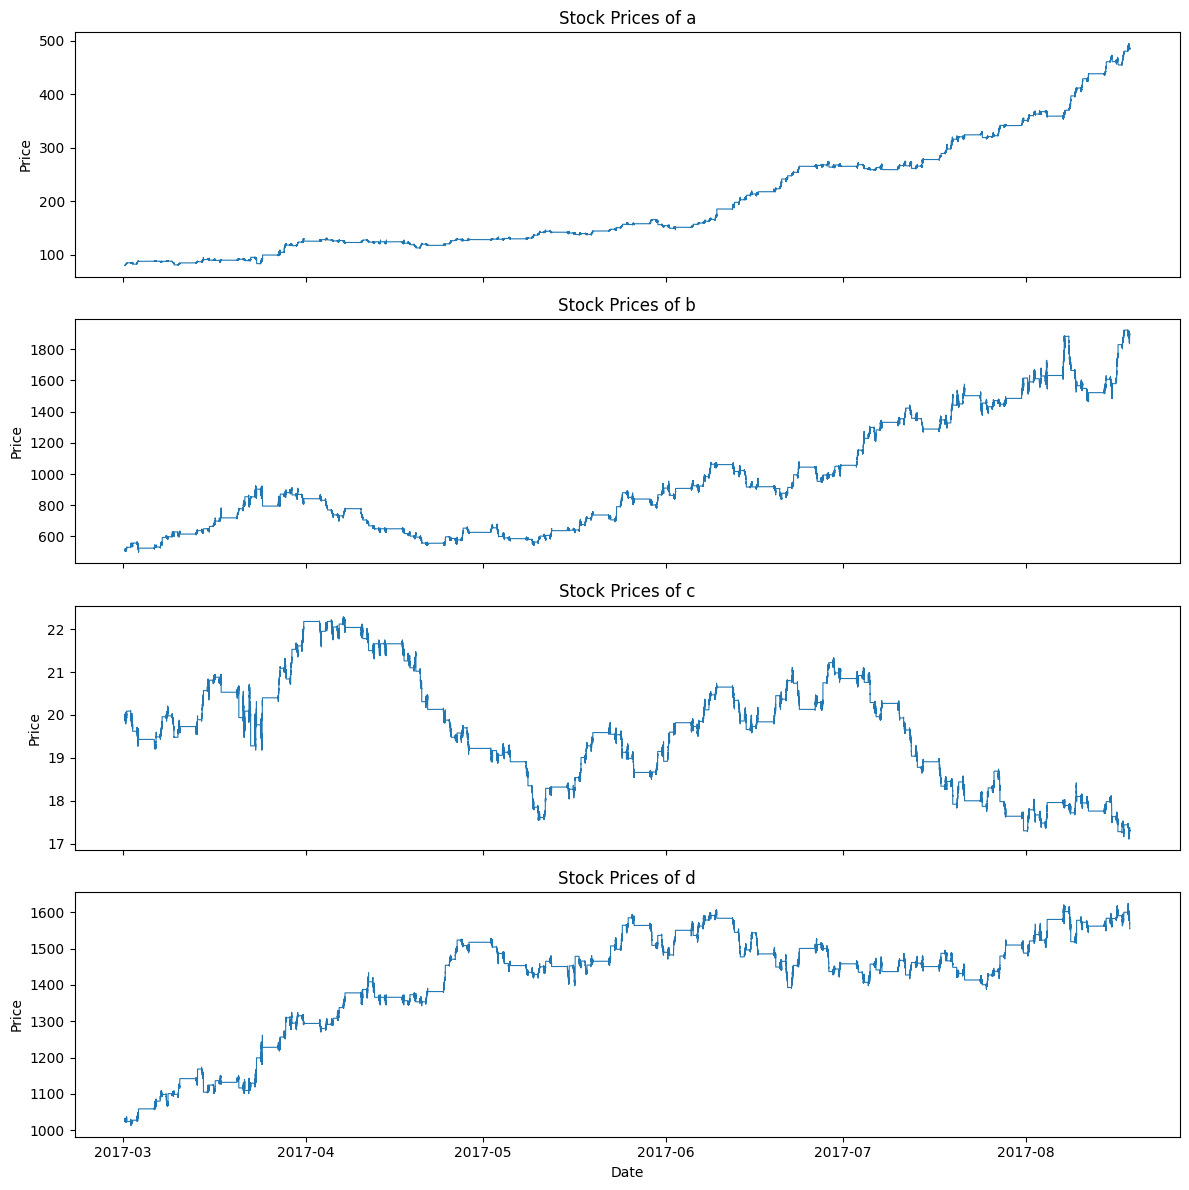

In [184]:
stock_frames = {
    stock: base_process(stock_file_paths, STOCK_SPLITS.get(stock, {}))
    for stock, stock_file_paths in groupby(
        raw_file_paths_ex_last,
        key=lambda file_path: file_path.name.split("_")[1],
    )
}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), sharex=True)

for ax, (stock, data) in zip(axes, stock_frames.items()):
    ax.step(data['ts'], data['price'], label=stock, lw=0.8)
    ax.set_title(f'Stock Prices of {stock}')
    ax.set_ylabel('Price')

plt.xlabel('Date')
plt.tight_layout()
plt.show()